In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST

import stochman

In [2]:
def get_subset_mnist(n: int = 1000):
    dataset = MNIST(root="data/", download=True)
    data = dataset.data[dataset.targets == 1]
    N = data.shape[0]
    idx = np.random.choice(np.arange(N), size=n)
    return data[idx]

# Read data
data = get_subset_mnist(n=1000)
data = data.reshape(data.shape[0], -1).to(torch.float)

In [11]:
# PCA
cov = torch.cov(data.t())
values, vectors = torch.linalg.eigh(cov)


In [4]:
proj = vectors[:, -2:] / values[-2:].sqrt().unsqueeze(0)
data = data @ proj
N, D = data.shape

## Part 1: Density metrics and basic geodesic computations

We first define a Riemannian metric derived from the local inverse-variance metric along with associated quantities. The metric is diagonal with elements corresponding to the inverse (reciprocal) of the local variance, which is defined as

        var(x) = \sum_n w_n(x) * (x_n - x)^2 + rho
        w_n(x) = exp(-|x_n - x| / 2sigma^2)

In [5]:
# Parameters for metric
sigma = 0.1
rho = 0.1

# Create metric
M = stochman.manifold.LocalVarMetric(data=data, sigma=sigma, rho=rho)

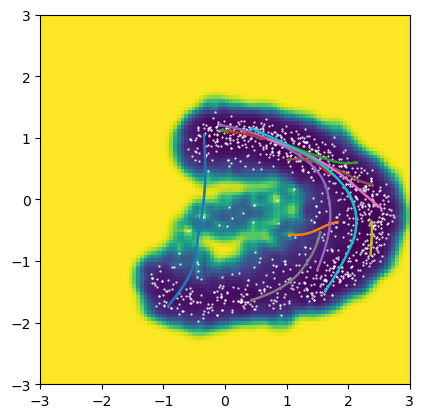

In [6]:
# Plot metric and data
plt.figure()
ran = torch.linspace(-3.0, 3.0, 100)
X, Y = torch.meshgrid([ran, ran], indexing="ij")
XY = torch.stack((X.flatten(), Y.flatten()), dim=1)  # 10000x2
gridM = M.metric(XY)  # 10000x2
Mim = gridM.sum(dim=1).reshape((100, 100)).detach().t()
plt.imshow(Mim, extent=(ran[0], ran[-1], ran[0], ran[-1]), origin="lower")
plt.plot(data[:, 0], data[:, 1], "w.", markersize=1)

# Compute geodesics in parallel
p0 = data[torch.randint(high=N, size=[10], dtype=torch.long)]  # 10xD
p1 = data[torch.randint(high=N, size=[10], dtype=torch.long)]  # 10xD
C, success = M.connecting_geodesic(p0, p1)
C.plot()
C.constant_speed(M)
C.plot()
plt.show()

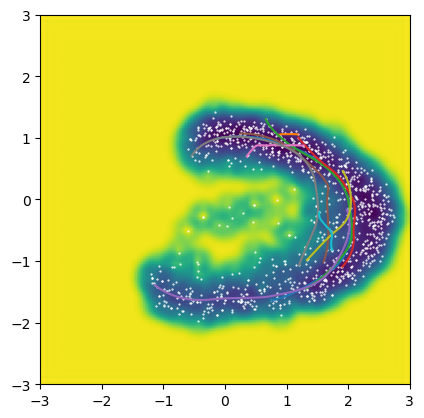

In [7]:
# Construct discretized manifold
DM = stochman.discretized_manifold.DiscretizedManifold()
DM.fit(M, [ran, ran], batch_size=100)

# Compute discretized geodesics
plt.figure()
ran2 = torch.linspace(-3.0, 3.0, 133)
X2, Y2 = torch.meshgrid([ran2, ran2], indexing="ij")
XY2 = torch.stack((X2.flatten(), Y2.flatten()), dim=1)  # 10000x2
DMim = DM.metric(XY2).log().sum(dim=1).view(133, 133).t()
plt.imshow(DMim, extent=(ran[0], ran[-1], ran[0], ran[-1]), origin="lower")
plt.plot(data[:, 0], data[:, 1], "w.", markersize=1)
p0 = data[torch.randint(high=N, size=[10], dtype=torch.long)]  # 10xD
p1 = data[torch.randint(high=N, size=[10], dtype=torch.long)]  # 10xD
C, success = DM.connecting_geodesic(p0, p1)
C.plot()

t = torch.linspace(0, 1, 100)
#with torch.no_grad():
#    print(DM.curve_length(C(t)))
#    print(DM.dist2(p0, p1).sqrt())
plt.show()

In [9]:
from stochman.geodesic import shooting_geodesic

p = C.begin
with torch.no_grad():
    v = C.deriv(torch.zeros(1))
    c, dc = shooting_geodesic(M, p, v, t=torch.linspace(0, 1, 100))
plt.plot(c[:,0, 0], c[:,1, 0], 'o')
plt.show()

RuntimeError: The size of tensor a (2) must match the size of tensor b (20) at non-singleton dimension 1